# Using Cython and stdpar to write GPU accelerated Python

This is a simple demonstration of to use Cython and [stdpar](https://developer.nvidia.com/blog/accelerating-standard-c-with-gpus-using-stdpar/) to write GPU accelerated Python.

In [1]:
import timeit

import numpy as np
import pandas as pd

from utils import format_time

In [2]:
def random_data(size):
    return np.random.randint(size, size=size, dtype="int32")

In [3]:
def time_sort(size, sort_func):    
    repeat = 10
    dt = 0
    for i in range(repeat):
        data = random_data(size)
        start = timeit.default_timer()
        sort_func(data)
        end = timeit.default_timer()
        dt += (end - start)
    return (dt) / repeat

## Timing NumPy `.sort()`

Below, we time the execution of Numpy's `.sort()` method for various different input sizes.

In [4]:
sizes = [100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]

In [5]:
numpy_times = pd.Series(
    [time_sort(s, lambda x: x.sort()) for s in sizes],
    index=sizes,
    name="ndarray.sort()"
)
numpy_times.map(format_time).to_frame()

,ndarray.sort()
100,45.78977823257446 µs
1000,100.04015639424325 µs
10000,647.4614143371582 µs
100000,5.242524016648531 ms
1000000,63.00307260826229 ms
10000000,733.7048726156354 ms


## Serial `std::sort`

In `cppsort_serial.pyx` below, we define a function `cppsort` that uses the C++ `std::sort` function to sort an input array:

In [6]:
%%writefile cppsort_serial.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort

def cppsort(int[:] x):
    sort(&x[0], &x[-1] + 1)
    

Writing cppsort_serial.pyx


Building the Cython extension:

In [7]:
!python setup.py build_ext --inplace

Compiling cppsort_serial.pyx because it changed.
[1/1] Cythonizing cppsort_serial.pyx
/home/ashwin/workspace/github/cython/cython/Cython/Compiler/Main.py:344: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/ashwin/workspace/github/shwina/stdpar-cython/cppsort_serial.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'cppsort_serial' extension
creating build
creating build/temp.linux-x86_64-3.8
gcc -pthread -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/ashwin/miniconda3/envs/cython-dev/include/python3.8 -c cppsort_serial.cpp -o build/temp.linux-x86_64-3.8/cppsort_serial.o -std=c++17
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
creating build/lib.linux-x86_64-3.8
g++ -pthread -shared -B /home/ashwin/miniconda3/e

Timing the execution:

In [8]:
from cppsort_serial import cppsort

cppsort_serial_times = pd.Series(
    [time_sort(s, lambda x: cppsort(x)) for s in sizes],
    index=sizes,
    name="std::sort (serial)"
)
cppsort_serial_times.map(format_time).to_frame()

,std::sort (serial)
100,12.905709445476532 µs
1000,84.42457765340805 µs
10000,934.119150042534 µs
100000,5.643531121313572 ms
1000000,63.44097591936588 ms
10000000,738.6250517331063 ms


## Parallel `std::sort` (CPU)

In `cppsort_parallel`, we use a [parallel execution policy](https://en.cppreference.com/w/cpp/algorithm/execution_policy_tag_t) with `std::sort`. When building the extension, we link the [tbb](https://github.com/oneapi-src/oneTBB) library, which provides a parallel implementation of `std::sort`.

In [9]:
%%writefile cppsort_parallel.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort
from libcpp.execution cimport par

def cppsort(int[:] x):
    sort(par, &x[0], &x[-1] + 1)

Writing cppsort_parallel.pyx


In [10]:
!python setup.py build_ext --inplace

Compiling cppsort_parallel.pyx because it changed.
[1/1] Cythonizing cppsort_parallel.pyx
/home/ashwin/workspace/github/cython/cython/Cython/Compiler/Main.py:344: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/ashwin/workspace/github/shwina/stdpar-cython/cppsort_parallel.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'cppsort_parallel' extension
gcc -pthread -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/ashwin/miniconda3/envs/cython-dev/include/python3.8 -c cppsort_parallel.cpp -o build/temp.linux-x86_64-3.8/cppsort_parallel.o -std=c++17
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
g++ -pthread -shared -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -L/home/ashwin/miniconda3/envs/cython-dev/lib

In [11]:
from cppsort_parallel import cppsort

cppsort_parallel_times = pd.Series(
    [time_sort(s, lambda x: cppsort(x)) for s in sizes],
    index=sizes,
    name="std::sort (parallel, CPU)"
)
cppsort_parallel_times.map(format_time)

100          243.1418746709824 µs
1000          122.850202023983 µs
10000       293.13676059246063 µs
100000      1.5057590790092945 ms
1000000     11.369879636913538 ms
10000000    132.21618216484785 ms
Name: std::sort (parallel, CPU), dtype: object

## GPU `std::sort` using -stdpar

Finally, in `cppsort_stdpar`, `cppsort` is rewritten to copy the input data to a temporary buffer. This is required because `-stdpar` does not work with externally allocated memory. Note that the extension is built with `nvc++` rather than `g++`:

In [12]:
%%writefile cppsort_stdpar.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort, copy_n
from libcpp.execution cimport par
from libcpp.vector cimport vector

def cppsort(int[:] x):
    """
    Sort the elements of x "in-place" using std::sort
    """
    cdef vector[int] vec
    vec.resize(len(x))
    copy_n(&x[0], len(x), vec.begin())
    sort(par, vec.begin(), vec.end())
    copy_n(vec.begin(), len(x), &x[0])

Writing cppsort_stdpar.pyx


In [13]:
!CC=/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ python setup.py build_ext --inplace

Compiling cppsort_stdpar.pyx because it changed.
[1/1] Cythonizing cppsort_stdpar.pyx
/home/ashwin/workspace/github/cython/cython/Cython/Compiler/Main.py:344: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/ashwin/workspace/github/shwina/stdpar-cython/cppsort_stdpar.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'cppsort_stdpar' extension
/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ -fPIC -stdpar -gpu=nordc -std=c++17 -I/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/include-stdpar -I/home/ashwin/miniconda3/envs/cython-dev/include/python3.8 -c cppsort_stdpar.cpp -o build/temp.linux-x86_64-3.8/cppsort_stdpar.o -std=c++17
"cppsort_stdpar.cpp", line 18153: warning: variable "__pyx_lineno" was set but
          never used
    int __pyx_lineno = 0;
        ^

"cppsort_stdpar.cpp", line 18154: warning: variable "__pyx_filename" was set
          b

/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ -shared -stdpar build/temp.linux-x86_64-3.8/cppsort_stdpar.o -L/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/lib -Wl,-R/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/lib -o build/lib.linux-x86_64-3.8/cppsort_stdpar.cpython-38-x86_64-linux-gnu.so
copying build/lib.linux-x86_64-3.8/cppsort_parallel.cpython-38-x86_64-linux-gnu.so -> 
copying build/lib.linux-x86_64-3.8/cppsort_serial.cpython-38-x86_64-linux-gnu.so -> 
copying build/lib.linux-x86_64-3.8/cppsort_stdpar.cpython-38-x86_64-linux-gnu.so -> 


In [14]:
from cppsort_stdpar import cppsort

cppsort_stdpar_times = pd.Series(
    [time_sort(s, lambda x: cppsort(x)) for s in sizes],
    index=sizes,
    name="std::sort (GPU with -stdpar)"
)
cppsort_stdpar_times.map(format_time)

100         15.196703560650347 ms
1000         462.5408910214901 µs
10000       1.2455964460968971 ms
100000       2.551164291799068 ms
1000000      3.739868476986885 ms
10000000     33.16338639706373 ms
Name: std::sort (GPU with -stdpar), dtype: object

## Comparing performance

Finally, we plot the speedups over NumPy:

In [15]:
all_times = pd.DataFrame([numpy_times, cppsort_serial_times, cppsort_parallel_times, cppsort_stdpar_times]).T
speedups = (1/all_times).multiply(numpy_times, axis=0)

In [16]:
speedups

,ndarray.sort(),std::sort (serial),"std::sort (parallel, CPU)",std::sort (GPU with -stdpar)
100,1.0,3.548025,0.188325,0.003013
1000,1.0,1.184965,0.814326,0.216284
10000,1.0,0.693125,2.208735,0.519800
100000,1.0,0.928944,3.481649,2.054954
1000000,1.0,0.993097,5.541226,16.846334
10000000,1.0,0.993339,5.549282,22.123943


<AxesSubplot:xlabel='Input array size', ylabel='Speedup over ndarray.sort()'>

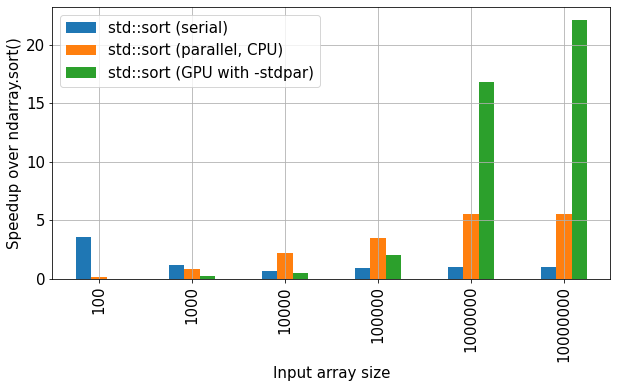

In [17]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})
speedups.iloc[:, 1:].plot(
    kind="bar", 
    xlabel="Input array size", 
    ylabel="Speedup over ndarray.sort()", 
    figsize=(10, 5),
    grid=True
)